In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
import astropy.coordinates as coord
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry,satellite
from astropy import units as u, constants as const
import glob
from scepter import skynet,obs
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
from matplotlib.gridspec import GridSpec
from matplotlib import animation

## This is a short pipeline to load the tles and visulise location of source to dynamic spectrum

In [6]:
### Cas A source in skycoord
casA=SkyCoord.from_name('Cas A')

#### OTT1
#  geographic longitude: 	 11° 55′ 11″
#  geographic latitude: 	 57° 23′ 37″
#  altitude above sea level: 	 16 m
#  diameter of telescope: 	 13.2 m
#  minimum elevation: 	  0°

#### OTT2
#  geographic longitude: 	 11° 55′ 08″
#  geographic latitude: 	 57° 23′ 35″
#  altitude above sea level: 	 16 m
#  diameter of telescope: 	 13.2 m
#  minimum elevation: 	  0°


longitude = coord.Angle("11d55m11s").deg
latitude = coord.Angle("+57d23m37s").deg
elevation = 16 * u.m
ott1=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

longitude = coord.Angle("11d55m08s").deg
latitude = coord.Angle("+57d23m35s").deg
elevation = 16 * u.m
ott2=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)



### telescopes are first in the 3d array, then tles, then time

def altaz_transformer(observatory,observing_time,source):
    observing_location = EarthLocation(lat=observatory.loc.lat, lon=observatory.loc.lon, height=observatory.loc.alt)
    aa = AltAz(location=observing_location, obstime=observing_time)
    newaa=source.transform_to(aa)
    return newaa

casAnew=altaz_transformer(ott1,Time.now(),casA)

print(casAnew.alt,casAnew.az)

30d24m18.79115038s 337d48m12.452436s


### load tles

In [7]:
tle_filedir='./tles_npzs_starlink/'
tlefile='20240429_120941.npz'
tles=np.load(tle_filedir+tlefile,allow_pickle=True)

response=tles['arr_0']
tle_string=response.item().text
# print(tle_string)
tles=np.array(cysgp4.tles_from_text(tle_string))


### satellites are in the form of [telescope, n_satellites,mjd]?
tles=tles[np.newaxis,:,np.newaxis]

tle_filedir2='./tles_npzs_oneweb/'
tlefile2='20240429_121643.npz'
tles2=np.load(tle_filedir2+tlefile2,allow_pickle=True)

response2=tles2['arr_0']
tle_string2=response2.item().text
# print(tle_string)
tles2=np.array(cysgp4.tles_from_text(tle_string2))


### satellites are in the form of [telescope, n_satellites,mjd]v
tles2=tles2[np.newaxis,:,np.newaxis]


#### load spectrum data

In [25]:
dateline='2024-04-29T12_37_48'
ant='SW' ## NE or SW
if ant == 'NE':
    bandname='NorthEastUpperband'
    observatories=np.array([ott1])
    observatories=observatories[:,np.newaxis,np.newaxis]   
elif ant == 'SW':
    bandname='SouthWestUpperband'
    observatories=np.array([ott2])
    observatories=observatories[:,np.newaxis,np.newaxis] 
fileL=sorted(glob.glob(f'./npdata/dataset_SA_{ant}_OTT{bandname}*.npz'))
print('loading data from',fileL[0])
data_file=np.load(fileL[0],allow_pickle=True)
data, telescope_az, telescope_el = data_file['data'], data_file['telescope_az'], data_file['telescope_el']
f_GHz, mjd = data_file['f_GHz'], data_file['mjd']
print(data.shape,telescope_az.shape,telescope_el.shape,f_GHz.shape,mjd.shape)
if len(fileL)>1:
    print('more than one file, loading all data')
    for filename in fileL[1:]:
        print('loading data from',filename)
        data_file=np.load(filename,allow_pickle=True)
        data=np.append(data,data_file['data'],axis=0)
        telescope_az=np.append(telescope_az,data_file['telescope_az'])
        telescope_el=np.append(telescope_el,data_file['telescope_el'])
        # f_GHz=np.append(f_GHz,data_file['f_GHz'])
        mjd=np.append(mjd,data_file['mjd'])

# data_file.keys will show the keys in the file,
# data, telescope_az, telescope_el, f_GHz, mjd

print(data.shape,telescope_az.shape,telescope_el.shape,f_GHz.shape,mjd.shape)
#### telescopes are first in the 3d array, then tles, then time

mjds=mjd[np.newaxis,np.newaxis,:]

print (mjds.shape,mjd.shape)

loading data from ./npdata/dataset_SA_SW_OTTSouthWestUpperband-2024-04-29T12_37_48.npz
(22434, 3001) (22434,) (22434,) (3001,) (22434,)
more than one file, loading all data
loading data from ./npdata/dataset_SA_SW_OTTSouthWestUpperband-2024-04-30T00_00_02.npz
loading data from ./npdata/dataset_SA_SW_OTTSouthWestUpperband-2024-05-01T00_00_01.npz
loading data from ./npdata/dataset_SA_SW_OTTSouthWestUpperband-2024-05-01T07_53_57.npz
loading data from ./npdata/dataset_SA_SW_OTTSouthWestUpperband-2024-05-02T00_00_01.npz
(127690, 3001) (127690,) (127690,) (3001,) (127690,)
(1, 1, 127690) (127690,)


### plot data

data size: (127690, 3001), channels:(3001,)
fmin: 10.0, fmax: 13.0


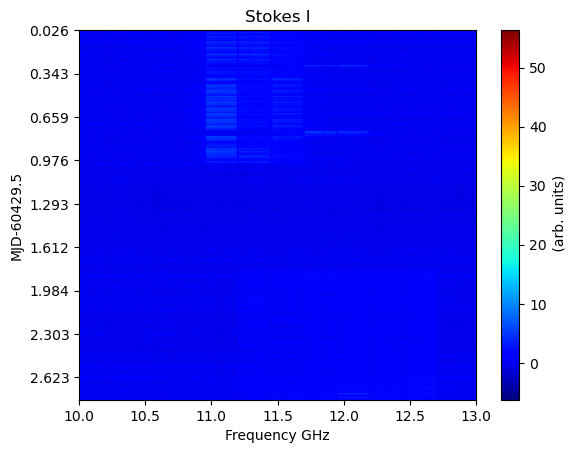

In [26]:
import matplotlib.colors as colors
# stokesI = (dataxx + datayy)/2
stokesI = data[:,:]
print(f"data size: {data.shape}, channels:{f_GHz.shape}")
print(f"fmin: {f_GHz.min()}, fmax: {f_GHz.max()}")
### frequency boundary here
fmin=9
fmax=14.1

#### tweak label steps here
ystep=15000
xstep=500

## apply bandpass correction and dB conversion here if needed
# stokesI=10*np.log10(stokesI)### convert to dB
bandpass=np.mean(stokesI[:100,:],axis=0)
stokesI = stokesI-bandpass


### make plot
plt.title('Stokes I')
plt.imshow(stokesI, aspect='auto', cmap='jet', norm=colors.Normalize(vmin=stokesI.min(), vmax=stokesI.max()))
plt.colorbar(label=' (arb. units)')
plt.xlabel('Frequency GHz')
plt.xticks(np.arange(0, data.shape[1], xstep), np.round(f_GHz[::xstep],1))
plt.ylabel(f"MJD-{np.round(mjd[0],1)}")
plt.yticks(np.arange(0, data.shape[0], ystep), np.round(mjd[::ystep]-np.round(mjd[0],1),3))
plt.xlim(np.where(f_GHz>fmin)[0][0],np.where(f_GHz<fmax)[0][-1])
plt.show()

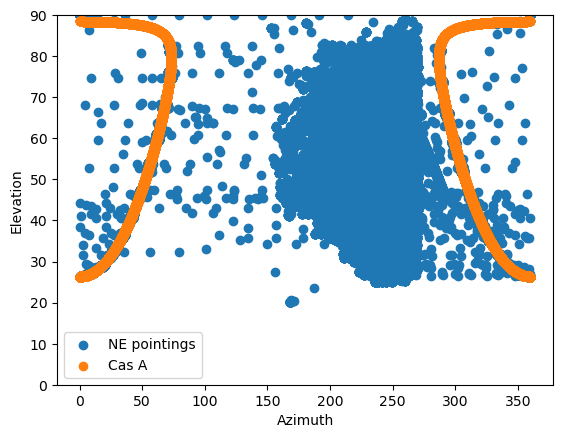

In [27]:
### not really useful plot to show satellite tracks.
casAnew=altaz_transformer(observatories[0,0,0],Time(mjd,format='mjd'),casA)
# plt.plot(topo_pos_az[0,0,:],topo_pos_el[0,0,:],label='satellites OTT1 location')
# plt.scatter(topo_pos_az[1,:,:],topo_pos_el[1,:,:],label='OTT2')
plt.scatter(telescope_az,telescope_el,label='NE pointings')
plt.scatter(casAnew.az.deg,casAnew.alt.deg,label='Cas A')
plt.xlabel('Azimuth')
plt.ylabel('Elevation')
plt.ylim(0,90)
plt.legend()
plt.show()

### determine transit times and onsource positions

In [31]:
telescope_el[np.where(telescope_el>90)[0]]=90+90-telescope_el[np.where(telescope_el>90)[0]]

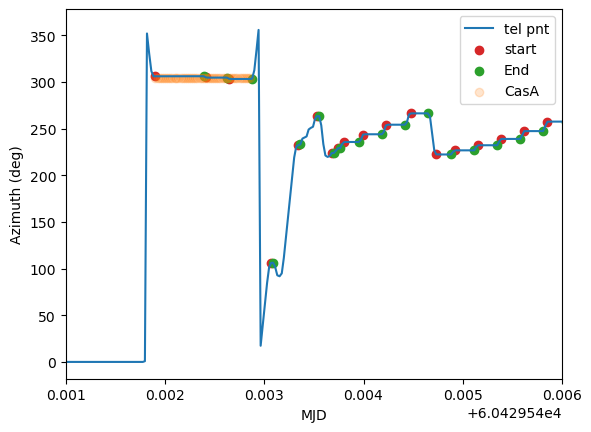

In [32]:
tel_pointing=coord.SkyCoord(telescope_az,telescope_el,unit='deg')
casA_pointing=coord.SkyCoord(casAnew.az,casAnew.alt,unit='deg')
onsource_mask=np.append(True,np.abs(np.diff(telescope_el))<1)*np.append(False,np.abs(np.diff(telescope_az))<1)
casA_mask=tel_pointing.separation(casA_pointing)<1*u.deg
cal_loc=np.where(casA_mask*onsource_mask)[0]


onsource_loc=np.where(onsource_mask)[0]
mask=(np.diff(onsource_loc)>1)[:]
insertvals=onsource_loc[1:][mask][:-1]-1 ### stupid way of finding the start of a transit observation
endvals=onsource_loc[:-1][mask][1:]
end_times=mjd[endvals]
start_times=mjd[insertvals]

mask_casA=(np.diff(cal_loc)>1)[:]
casA_start=cal_loc[1:][mask_casA][:-1]-1
casA_end=cal_loc[:-1][mask_casA][1:]
# print(casA_start,casA_end)

from astropy.time import Time

times=Time(mjd,format='mjd')
start_times=Time(start_times,format='mjd')
end_times=Time(end_times,format='mjd')  


onsource_loc=np.insert(onsource_loc,np.where(mask)[0][:-1],insertvals)

pnts=coord.SkyCoord(telescope_az[onsource_mask],telescope_el[onsource_mask],unit='deg',frame='altaz')

plt.plot(mjd,telescope_az,label='tel pnt')
# plt.scatter(mjd[onsource_loc],telescope_az[onsource_loc],label='on source',color='red')
plt.scatter(mjd[insertvals],telescope_az[insertvals],label='start',color='C3')
plt.scatter(mjd[endvals],telescope_az[endvals],label='End',color='C2')
plt.scatter(mjd[casA_mask],casAnew.az[casA_mask],label='CasA',color='C1',alpha=0.2)
plt.legend()
plt.ylabel('Azimuth (deg)')
plt.xlabel('MJD')
plt.xlim(60429.541,60429.546)
plt.show()

# print(pnts)

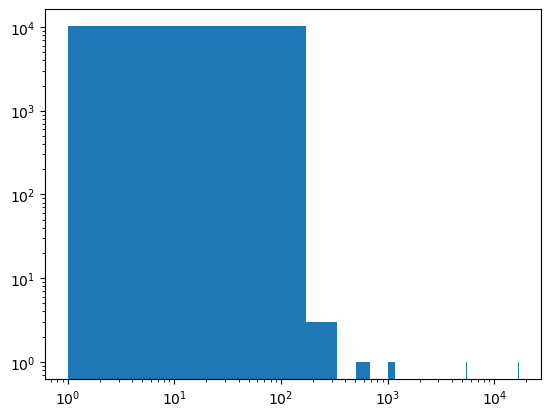

In [38]:
gaps=endvals-insertvals
plt.hist(gaps,bins=100)
plt.yscale('log')
plt.xscale('log')
plt.show()

#### test operation within time cutouts for tle coordinates

In [39]:
### get time points for tle coordinates
for i,j in zip(insertvals[:10],endvals[:10]):
    if j-i<2:
        print('skipping short observation')
        continue
    ### data prep
    cutout=stokesI[i:j,:]
    mid=np.argmax(np.sum(cutout,axis=1))
    cutout_mjd=mjds[:,:,i:j] ### satellite arrays are in the form of [telescope, n_satellites,mjd]
    cutout_coords=coord.SkyCoord(telescope_az[mid],telescope_el[mid],unit='deg')
    print(f'loading tles for {np.round(mjd[j],5)} to {np.round(mjd[j],5)}',end="\r")
    sat_info=cysgp4.propagate_many(cutout_mjd,tles,observers=observatories[0],
            do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
    sat_info2=cysgp4.propagate_many(cutout_mjd,tles2,observers=observatories[0],
            do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
    
    topo_pos = sat_info['topo']
    topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., idx] for idx in range(4))
    topo_pos2 = sat_info2['topo']
    topo_pos_az2, topo_pos_el2, topo_pos_dist2, _ = (topo_pos2[..., idx] for idx in range(4))
    
    # print(f"length is {j-i}, peak length is {len(peak)}, tle coord array shape is{topo_pos_az2.shape}")
    satellite_coords=coord.SkyCoord(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],unit='deg')
    satellite_coords2=coord.SkyCoord(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],unit='deg')
    
    dist=cutout_coords.separation(satellite_coords)
    dist2=cutout_coords.separation(satellite_coords2)
    # print('satellite coord shape',satellite_coords.shape,dist.shape)
    closest_sat=np.argmin(dist)
    closest_sat2=np.argmin(dist2)
    # print(closest_sat,dist[closest_sat])
    bestsat_coord=coord.SkyCoord(topo_pos_az[0,closest_sat,:],topo_pos_el[0,closest_sat,:],unit='deg')
    beamsep=cutout_coords.separation(bestsat_coord)
    bestsatname=tles[0,closest_sat,0].int_designator
    bestsatname=bestsatname.decode('utf-8')

    bestsat_coord2=coord.SkyCoord(topo_pos_az2[0,closest_sat2,:],topo_pos_el2[0,closest_sat2,:],unit='deg')
    beamsep2=cutout_coords.separation(bestsat_coord2)
    bestsatname2=tles2[0,closest_sat2,0].int_designator
    bestsatname2=bestsatname2.decode('utf-8')
    if dist[closest_sat]>10*u.deg:
        if dist2[closest_sat2]>10*u.deg:
            print('oneweb satellite is also too far away > 10 degrees, check the data')
            print(f"closest sateliite is {bestsatname2}, closest distance is {dist2[closest_sat2]}")
        else:
            print('starlink satellite is too far away > 10 degrees, check the data')
            print(f"closest sateliite is {bestsatname}, closest distance is {dist[closest_sat]}")



oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 21090AE , closest distance is 24.913394561845074 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 21090AE , closest distance is 27.932520917664327 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23043AJ , closest distance is 27.969552935002493 deg
skipping short observation
skipping short observation
skipping short observation
skipping short observation
skipping short observation
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23029C  , closest distance is 23.75758826582095 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23029C  , closest distance is 25.94106231004247 deg


#### generate all tle positions,may take a while

In [40]:
# # print(observatories,tles.shape,mjds.shape)
# sat_info=cysgp4.propagate_many(mjds,tles,observers=observatories,
# do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
# print('constellation 1 loaded')
# # print(observatories,tles.shape,mjds.shape)
# sat_info2=cysgp4.propagate_many(mjds,tles2,observers=observatories,
# do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
# print('constellation 2 loaded')


#### get topo positions

In [41]:
# topo_pos = sat_info['topo']
# # sat_azel = sat_info['sat_azel']  ### check cysgp4 for satellite frame orientation description

# # eci_pos_x, eci_pos_y, eci_pos_z = (eci_pos[..., i] for i in range(3))
# topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., i] for i in range(4))
# # obs_az, obs_el, obs_dist = (sat_azel[..., i] for i in range(3))

# topo_pos2 = sat_info2['topo']
# topo_pos_az2, topo_pos_el2, topo_pos_dist2, _ = (topo_pos2[..., i] for i in range(4))



### preview CasA pointings dynamic spectrum

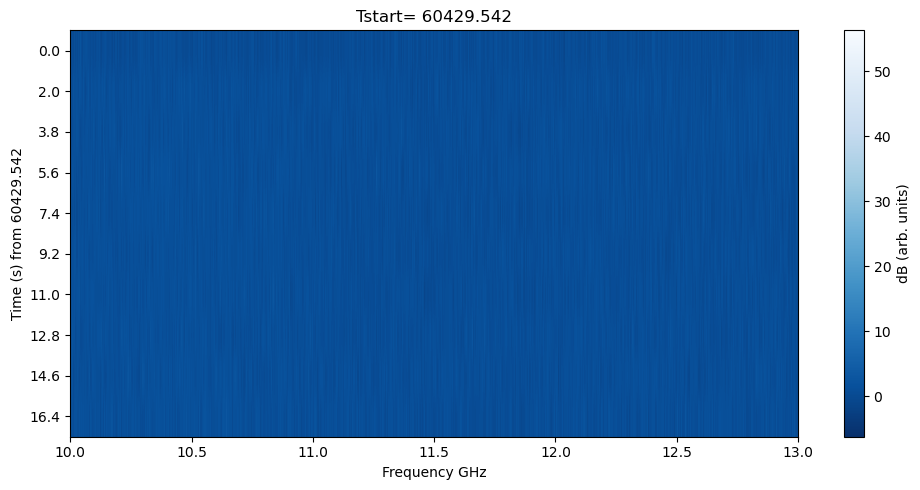

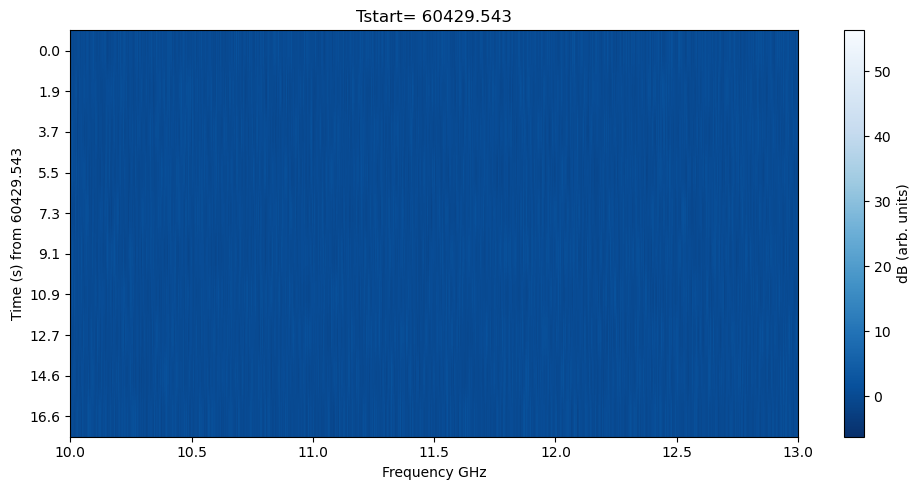

In [42]:
### xstep and ystep to get the desired number of ticks on the plot
xstep=500
ystep=100
### frequency range to plot, bigger than 10-13 GHz to plot whole
fmin=9.9
fmax=13.5
### snapshot label name here

for i,j in zip(casA_start[0:2],casA_end[0:2]):
    cutout=stokesI[i:j,:]
    plt.figure(figsize=(10,5))
    plt.title(f'Tstart= {np.round(mjd[i],3)}')
    plt.imshow(cutout, aspect='auto', cmap='Blues_r', norm=colors.Normalize(vmin=stokesI.min(), vmax=stokesI.max()))
    plt.colorbar(label='dB (arb. units)')
    plt.xlabel('Frequency GHz')
    plt.xticks(np.arange(0, data.shape[1], xstep), np.round(f_GHz[::xstep],1))
    plt.ylabel(f"Time (s) from {np.round(mjd[i],3)}")
    yticks=np.round((mjd[i:j]-mjd[i])*24*60*60,1)
    plt.yticks(np.arange(j-i), yticks)
    plt.xlim(np.where(f_GHz>fmin)[0][0],np.where(f_GHz<fmax)[0][-1])
    plt.tight_layout()
    # plt.savefig(figsave_dir+tlabel+f'sat_scan_{np.round(mjd[i],3)}.png')    
    
    plt.show()
#     plt.close()

#### preview dynamic spectrum plotting

starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 22001AT , closest distance is 13.784283861221187 deg


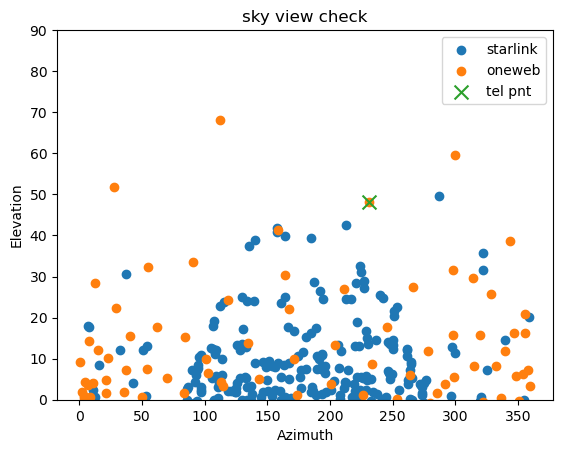

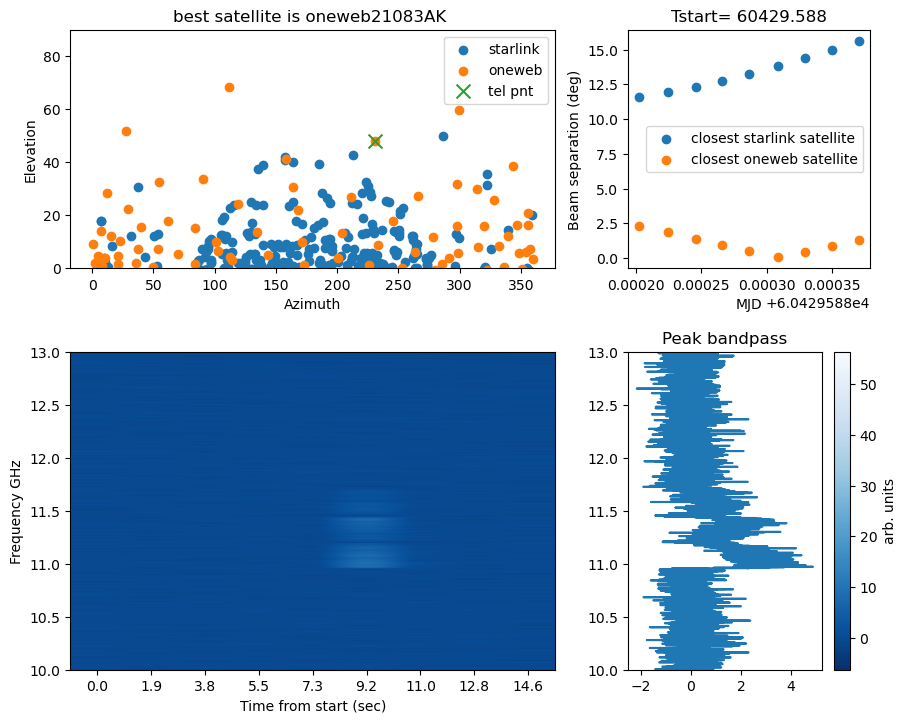

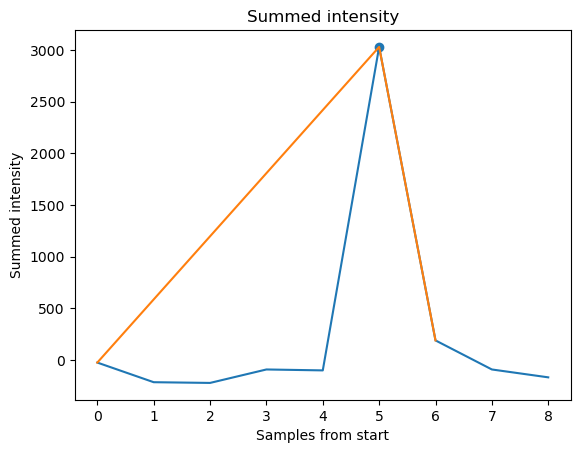

In [44]:
### general plotting settings
figsave_dir='./snapshots/'
### directory to save the cutouts
### xstep and ystep to get the desired number of ticks on the plot
xstep=500
ystep=1
### frequency range to plot, bigger than 10-13 GHz to plot whole
fmin=9.9
fmax=13.5
### snapshot label name here
tlabel=ant+'_spec'


i=insertvals[200]
j=endvals[200]


### data prep

if j-i<2:
        print('skipping short observation')
        plt.plot(cutout[0])
        plt.show()
        # continue
else:
        cutout=stokesI[i:j,:]
        # print(f"cutout shape is {cutout.shape}")
        mid=np.argmax(np.sum(cutout,axis=1))
        cutout_mjd=mjds[:,:,i:j] ### satellite arrays are in the form of [telescope, n_satellites,mjd]
        cutout_coords=coord.SkyCoord(telescope_az[mid+i],telescope_el[mid+i],unit='deg')
        print(f'loading tles for {np.round(mjd[i],5)} to {np.round(mjd[j],5)}',end="\r")


        sat_info=cysgp4.propagate_many(cutout_mjd,tles,observers=observatories[0],
                do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
        sat_info2=cysgp4.propagate_many(cutout_mjd,tles2,observers=observatories[0],
                do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 

        topo_pos = sat_info['topo']
        topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., idx] for idx in range(4))
        topo_pos2 = sat_info2['topo']
        topo_pos_az2, topo_pos_el2, topo_pos_dist2, _ = (topo_pos2[..., idx] for idx in range(4))

        # print(f"length is {j-i}, peak length is {len(peak)}, tle coord array shape is{topo_pos_az2.shape}")
        satellite_coords=coord.SkyCoord(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],unit='deg')
        satellite_coords2=coord.SkyCoord(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],unit='deg')

        dist=cutout_coords.separation(satellite_coords)
        dist2=cutout_coords.separation(satellite_coords2)
        # print('satellite coord shape',satellite_coords.shape,dist.shape)
        closest_sat=np.argmin(dist)
        closest_sat2=np.argmin(dist2)
        # print(closest_sat,dist[closest_sat])
        bestsat_coord=coord.SkyCoord(topo_pos_az[0,closest_sat,:],topo_pos_el[0,closest_sat,:],unit='deg')
        beamsep=cutout_coords.separation(bestsat_coord)
        bestsatname=tles[0,closest_sat,0].int_designator
        bestsatname=bestsatname.decode('utf-8')

        bestsat_coord2=coord.SkyCoord(topo_pos_az2[0,closest_sat2,:],topo_pos_el2[0,closest_sat2,:],unit='deg')
        beamsep2=cutout_coords.separation(bestsat_coord2)
        bestsatname2=tles2[0,closest_sat2,0].int_designator
        bestsatname2=bestsatname2.decode('utf-8')

        if dist[closest_sat]>10*u.deg:
                if dist2[closest_sat2]>10*u.deg:
                        print('oneweb satellite is also too far away > 10 degrees, check the data')
                        print(f"closest sateliite is {bestsatname2}, closest distance is {dist2[closest_sat]}")
                else:
                        print('starlink satellite is too far away > 10 degrees, check the data')
                        print(f"closest sateliite is {bestsatname}, closest distance is {dist[closest_sat]}")
        if beamsep[0]<beamsep2[0]:
                bestmatch='starlink'+bestsatname
        else:
                bestmatch='oneweb'+bestsatname2

        peak=np.where(np.sum(cutout,axis=1)>np.percentile(np.sum(cutout,axis=1),68))
        mjdticks_insec=np.round((mjd[i:j]-mjd[i])*24*3600,2)
        
        tick_intv=np.arange(0,j-i,ystep)

        ### sky view check
        plt.title('sky view check')
        # plt.plot(topo_pos_az[0,closest_sat,i:j],topo_pos_el[0,closest_sat,i:j],label='satellite')
        # plt.plot(telescope_az[i:j],telescope_el[i:j],label='tel pnt')
        plt.scatter(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],label='starlink')
        plt.scatter(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],label='oneweb')

        plt.scatter(telescope_az[mid+i],telescope_el[mid+i],label='tel pnt',s=100,marker='x' )
        plt.ylim(0,90)
        plt.xlabel('Azimuth')
        plt.ylabel('Elevation')
        plt.legend()
        plt.show()




        #### main figure
        fig=plt.figure(figsize=(10,8))
        gs = GridSpec(2,2,width_ratios=(4, 2), height_ratios=(3, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.2, hspace=0.3)
        ax1 = plt.subplot(gs[0,0])
        ax2 = plt.subplot(gs[0,1])
        ax3 = plt.subplot(gs[1,0])
        ax4 = plt.subplot(gs[1,1],sharey=ax3)
        ax2.set_title(f'Tstart= {np.round(mjd[i],3)}')



        ### ax1 satellite track and telescope pointing
        ax1.set_title(f'best satellite is {bestmatch}')
        ax1.scatter(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],label='starlink')
        ax1.scatter(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],label='oneweb')
        ax1.scatter(telescope_az[mid+i],telescope_el[mid+i],label='tel pnt',s=100,marker='x' )
        ax1.set_xlabel('Azimuth')
        ax1.set_ylabel('Elevation')
        ax1.set_ylim(0,90)

        ax1.legend()

        ### ax2 time evolution, multiple info, 

        ax2.scatter(mjd[i:j],beamsep,label='closest starlink satellite')
        ax2.scatter(mjd[i:j],beamsep2,label='closest oneweb satellite')

        ax2.set_ylabel('Beam separation (deg)')
        ax2.set_xlabel('MJD')
        # ax2.set_xticks(np.arange(j-i), mjdticks)
        ax2.legend()


        ####ax3 is the dynamic spectrum
        img=ax3.imshow(cutout.T, aspect='auto', cmap='Blues_r', norm=colors.Normalize(vmin=stokesI.min(), vmax=stokesI.max()))

        ax3.set_ylabel('Frequency GHz')
        ax3.set_yticks(np.arange(0, data.shape[1], xstep), np.round(f_GHz[::xstep],1))
        # plt.ylabel(f"MJD-{np.round(mjd[i],3)}")
        ax3.set_xlabel(f"Time from start (sec)")
        ax3.set_xticks(tick_intv, mjdticks_insec[tick_intv])
        ax3.set_ylim(np.where(f_GHz>fmin)[0][0],np.where(f_GHz<fmax)[0][-1])
        cbar=fig.colorbar(img,ax=ax4)
        cbar.set_label(label='arb. units')

        ### ax4 frequency bandpass at peak
        ax4.set_title('Peak bandpass')
        ax4.plot(np.mean(cutout[peak[0],:],axis=0),np.arange(cutout.shape[1]))





        #### show
        plt.show()


        ## just to doublecheck I'm capturing the right time
        plt.title('Summed intensity')
        plt.plot(np.sum(cutout,axis=1))
        plt.plot(peak[0],np.sum(cutout,axis=1)[peak[0]])
        plt.scatter(mid,np.sum(cutout,axis=1)[mid])
        plt.xlabel('Samples from start')
        plt.ylabel('Summed intensity')
        plt.show()
        # plt.close()

In [45]:


for i,j in zip(insertvals,endvals):
    if j-i<2:
        print('skipping short observation')
        # plt.plot(cutout[0])
        # plt.show()
        continue
    ### data prep
    cutout=stokesI[i:j,:]
    mid=np.argmax(np.sum(cutout,axis=1))
    cutout_mjd=mjds[:,:,i:j] ### satellite arrays are in the form of [telescope, n_satellites,mjd]
    cutout_coords=coord.SkyCoord(telescope_az[mid+i],telescope_el[mid+i],unit='deg')
    print(f'loading tles for {np.round(mjd[i],5)} to {np.round(mjd[j],5)}',end="\r")


    sat_info=cysgp4.propagate_many(cutout_mjd,tles,observers=observatories[0],
            do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
    sat_info2=cysgp4.propagate_many(cutout_mjd,tles2,observers=observatories[0],
            do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 

    topo_pos = sat_info['topo']
    topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., idx] for idx in range(4))
    topo_pos2 = sat_info2['topo']
    topo_pos_az2, topo_pos_el2, topo_pos_dist2, _ = (topo_pos2[..., idx] for idx in range(4))

    # print(f"length is {j-i}, peak length is {len(peak)}, tle coord array shape is{topo_pos_az2.shape}")
    satellite_coords=coord.SkyCoord(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],unit='deg')
    satellite_coords2=coord.SkyCoord(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],unit='deg')

    dist=cutout_coords.separation(satellite_coords)
    dist2=cutout_coords.separation(satellite_coords2)
    # print('satellite coord shape',satellite_coords.shape,dist.shape)
    closest_sat=np.argmin(dist)
    closest_sat2=np.argmin(dist2)
    # print(closest_sat,dist[closest_sat])
    bestsat_coord=coord.SkyCoord(topo_pos_az[0,closest_sat,:],topo_pos_el[0,closest_sat,:],unit='deg')
    beamsep=cutout_coords.separation(bestsat_coord)
    bestsatname=tles[0,closest_sat,0].int_designator
    bestsatname=bestsatname.decode('utf-8')

    bestsat_coord2=coord.SkyCoord(topo_pos_az2[0,closest_sat2,:],topo_pos_el2[0,closest_sat2,:],unit='deg')
    beamsep2=cutout_coords.separation(bestsat_coord2)
    bestsatname2=tles2[0,closest_sat2,0].int_designator
    bestsatname2=bestsatname2.decode('utf-8')
 
    if dist[closest_sat]>10*u.deg:
        if dist2[closest_sat2]>10*u.deg:
            print('oneweb satellite is also too far away > 10 degrees, check the data')
            print(f"closest sateliite is {bestsatname2}, closest distance is {dist2[closest_sat2]}")
        else:
            print('starlink satellite is too far away > 10 degrees, check the data')
            print(f"closest sateliite is {bestsatname}, closest distance is {dist[closest_sat]}")
    if beamsep[0]<beamsep2[0]:
        bestmatch='starlink'+bestsatname
    else:
        bestmatch='oneweb'+bestsatname2

    peak=np.where(np.sum(cutout,axis=1)>np.percentile(np.sum(cutout,axis=1),68))
    mjdticks_insec=np.round((mjd[i:j]-mjd[i])*24*3600,2)
    timestep=5
    tick_intv=np.arange(0,j-i,timestep)
    spectra=np.mean(cutout[peak[0],:],axis=0)
    #### main figure
    fig=plt.figure(figsize=(10,8))
    gs = GridSpec(2,2,width_ratios=(4, 3), height_ratios=(3, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.2, hspace=0.3)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,0])
    ax4 = plt.subplot(gs[1,1],sharey=ax3)
    ax2.set_title(f'Tstart= {np.round(mjd[i],3)}')



    ### ax1 satellite track and telescope pointing
    ax1.set_title(f'best satellite is {bestmatch}')
    ax1.scatter(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],label='starlink')
    ax1.scatter(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],label='oneweb')
    ax1.scatter(telescope_az[mid+i],telescope_el[mid+i],label='tel pnt',s=100,marker='x' )
    ax1.set_xlabel('Azimuth')
    ax1.set_ylabel('Elevation')
    ax1.set_ylim(0,90)

    ax1.legend()

    ### ax2 time evolution, multiple info, 
    
    ax2.plot(mjd[i:j],beamsep,label='closest starlink satellite')
    ax2.plot(mjd[i:j],beamsep2,label='closest oneweb satellite')

    ax2.set_ylabel('Beam separation (deg)')
    ax2.set_xlabel('MJD')
    # ax2.set_xticks(np.arange(j-i), mjdticks)
    ax2.legend()


    ####ax3 is the dynamic spectrum
    img=ax3.imshow(cutout.T, aspect='auto', cmap='Blues_r', norm=colors.Normalize(vmin=stokesI.min(), vmax=stokesI.max()))

    ax3.set_ylabel('Frequency GHz')
    ax3.set_yticks(np.arange(0, data.shape[1], xstep), np.round(f_GHz[::xstep],1))
    # plt.ylabel(f"MJD-{np.round(mjd[i],3)}")
    ax3.set_xlabel(f"Time from start (sec)")
    ax3.set_xticks(tick_intv, mjdticks_insec[tick_intv])
    ax3.set_ylim(np.where(f_GHz>fmin)[0][0],np.where(f_GHz<fmax)[0][-1])
    cbar=fig.colorbar(img,ax=ax4)
    cbar.set_label(label='arb. units')

    ### ax4 frequency bandpass at peak
    ax4.set_title('Peak bandpass')
    
    ax4.plot(spectra,np.arange(spectra.shape[0]))
    ax4.set_xlabel('Intensity')
    ax4.set_xlim(-5,)
    # ax4.set_xscale('log')
    



    ## save show and close
    plt.savefig(figsave_dir+tlabel+f"_satscan_{np.round(mjd[i],5)}.png")        
    # plt.show()
    plt.close()

oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 21045E  , closest distance is 10.865857503785747 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 21045E  , closest distance is 13.957068537505284 deg
skipping short observation64 to 60429.54288
skipping short observation
skipping short observation
skipping short observation
skipping short observation
starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 20019BM , closest distance is 23.013515733469497 deg
starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 20019BM , closest distance is 25.08223329648976 deg
starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 20019BM , closest distance is 31.009246762335543 deg
starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 22053AW , closest distance is 38.78418752267628 deg
starlink satelli